In [46]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [47]:
import os
os.environ["OMP_NUM_THREADS"] = "5"  # 设置线程数为5，避免内存泄漏


In [48]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False 

In [49]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions,plot_xgb_feature_importance


In [50]:
########################   读取数据  #########################################
sheet = pd.read_excel('data_input/中国10债Non-Trend.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['中国10年期国债收益率Non-Trend/F0.2'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet
sheet.columns

Index(['中国10年期国债收益率Non-Trend/F0.2', 'M2同比', 'M1同比', '新增人民币贷款/中长期同差',
       '中国核心CPI当月同比', '70大中城市二手房价环比Non-Trend/F0.1', 'DR007利率/15DMA同差',
       '螺纹期货价格60日环比', '南华工业品指数60日环比', 'CNH HIBOR/3M',
       '10年期美国国债收益率Non-Trend/F0.2', '十年期国债动量', '一线二手房挂牌价指数4周环差',
       '新增社融滚动12个月累计同比', '沪深300'],
      dtype='object')

In [51]:

# 有月度数据 所以 数据 处理逻辑 就是 全部填充 然后再变成 工作日数据
#############  处理缺失值 ##############
fill_methods = {
    'M2同比':'interpolate', 
    'M1同比':'interpolate', 
    '新增人民币贷款/中长期同差':'interpolate',
    '中国核心CPI当月同比':'interpolate', 
    '70大中城市二手房价环比Non-Trend/F0.1':'interpolate', 
    'DR007利率/15DMA同差':'interpolate',
    '螺纹期货价格60日环比':'interpolate', 
    '南华工业品指数60日环比':'interpolate', 
#    'CNH HIBOR/3M':'interpolate',
    '10年期美国国债收益率Non-Trend/F0.2':'interpolate',
    '十年期国债动量' :'interpolate',
    '一线二手房挂牌价指数4周环差':'interpolate',
    '新增社融滚动12个月累计同比':'interpolate',
    '沪深300':'interpolate'

} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
last_day = sheet['中国10年期国债收益率Non-Trend/F0.2'].last_valid_index()
sheet = sheet.reset_index().rename(columns={'index': 'Date'})
########## 只保留工作日数据(周一到周五) ##########
sheet = sheet[sheet['Date'].dt.dayofweek < 5]
sheet_daily = sheet.copy()
########################   因子处理  #########################################

sheet_daily['M2同比_提前140天'] = sheet_daily['M2同比'].shift(140)
sheet_daily['M1同比_提前60天'] = sheet_daily['M1同比'].shift(60)
sheet_daily['新增人民币贷款/中长期同差_提前160天'] = sheet_daily['新增人民币贷款/中长期同差'].shift(180)
sheet_daily['中国核心CPI当月同比_提前55天'] = sheet_daily['中国核心CPI当月同比'].shift(55)
sheet_daily['70大中城市二手房价环比Non-Trend/F0.1_提前170天'] = sheet_daily['70大中城市二手房价环比Non-Trend/F0.1'].shift(170)
sheet_daily['DR007利率/15DMA同差_提前45天'] = sheet_daily['DR007利率/15DMA同差'].shift(45)
sheet_daily['螺纹期货价格60日环比_提前20天'] = sheet_daily['螺纹期货价格60日环比'].shift(20)
sheet_daily['南华工业品指数60日环比_提前15天'] = sheet_daily['南华工业品指数60日环比'].shift(15)
sheet_daily['CNH HIBOR/3M_提前60天'] = sheet_daily['CNH HIBOR/3M'].shift(60)
sheet_daily['10年期美国国债收益率Non-Trend/F0.2_提前20天'] = sheet_daily['10年期美国国债收益率Non-Trend/F0.2'].shift(20)
sheet_daily['十年期国债动量_提前20天'] = sheet_daily['十年期国债动量'].shift(20)
sheet_daily['一线二手房挂牌价指数4周环差_提前25天'] = sheet_daily['一线二手房挂牌价指数4周环差'].shift(25)
sheet_daily['新增社融滚动12个月累计同比_提前20天'] = sheet_daily['新增社融滚动12个月累计同比'].shift(20)
sheet_daily['沪深300_提前15天'] = sheet_daily['沪深300'].shift(15)
sheet_daily['沪深300_提前16天'] = sheet_daily['沪深300'].shift(16)
sheet_daily['沪深300_提前20天'] = sheet_daily['沪深300'].shift(20)
sheet_daily = sheet_daily[sheet_daily['Date'] >= '2023-08-01']
  
############ 不同因子有效期不同  ##########
sheet_daily['10年期美国国债收益率Non-Trend/F0.2_提前20天_2023-01-01之后'] = sheet_daily['10年期美国国债收益率Non-Trend/F0.2_提前20天'].loc[sheet_daily['Date'] >= '2023-01-01']

#############  逆序处理 ##############
#sheet_daily['央行国债净买入额/1个月_提前50天_逆序'] = reverse_column(sheet_daily, '央行国债净买入额/1个月_提前50天')

#############  删除预测指标最后一天之前 为空值的一整行  ##############
sheet_daily = sheet_daily[(sheet_daily['Date'] > last_day) | sheet_daily['中国10年期国债收益率Non-Trend/F0.2'].notna()]


In [52]:
sheet_daily.columns

Index(['Date', '中国10年期国债收益率Non-Trend/F0.2', 'CNH HIBOR/3M', 'M2同比', 'M1同比',
       '新增人民币贷款/中长期同差', '中国核心CPI当月同比', '70大中城市二手房价环比Non-Trend/F0.1',
       'DR007利率/15DMA同差', '螺纹期货价格60日环比', '南华工业品指数60日环比',
       '10年期美国国债收益率Non-Trend/F0.2', '十年期国债动量', '一线二手房挂牌价指数4周环差',
       '新增社融滚动12个月累计同比', '沪深300', 'M2同比_提前140天', 'M1同比_提前60天',
       '新增人民币贷款/中长期同差_提前160天', '中国核心CPI当月同比_提前55天',
       '70大中城市二手房价环比Non-Trend/F0.1_提前170天', 'DR007利率/15DMA同差_提前45天',
       '螺纹期货价格60日环比_提前20天', '南华工业品指数60日环比_提前15天', 'CNH HIBOR/3M_提前60天',
       '10年期美国国债收益率Non-Trend/F0.2_提前20天', '十年期国债动量_提前20天',
       '一线二手房挂牌价指数4周环差_提前25天', '新增社融滚动12个月累计同比_提前20天', '沪深300_提前15天',
       '沪深300_提前16天', '沪深300_提前20天',
       '10年期美国国债收益率Non-Trend/F0.2_提前20天_2023-01-01之后'],
      dtype='object')

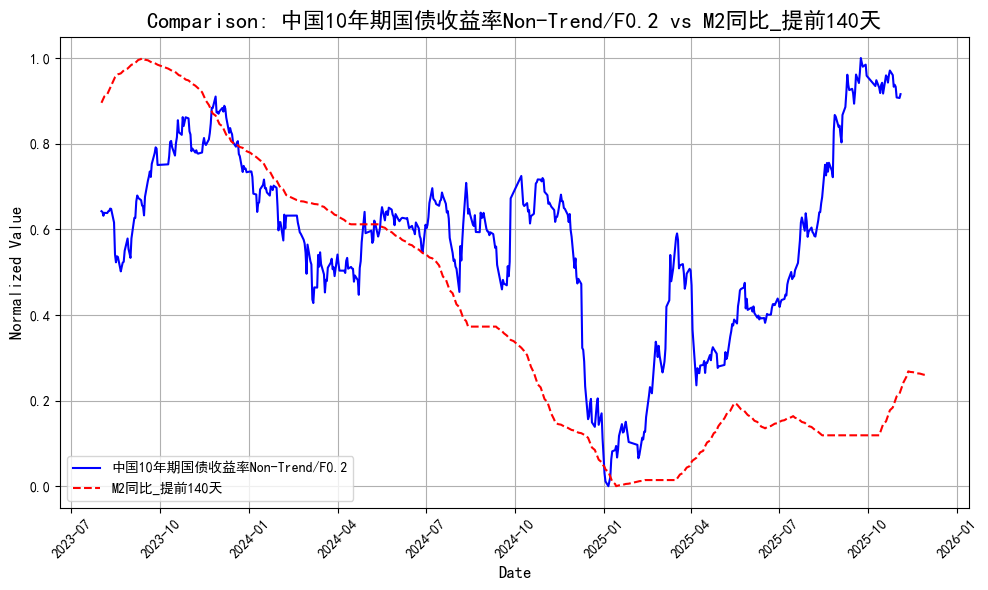

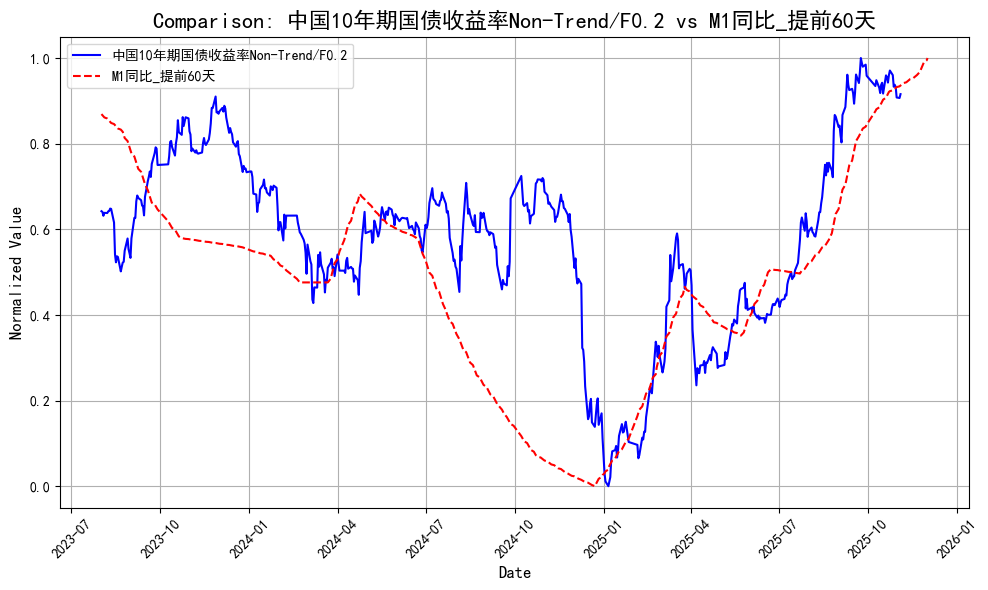

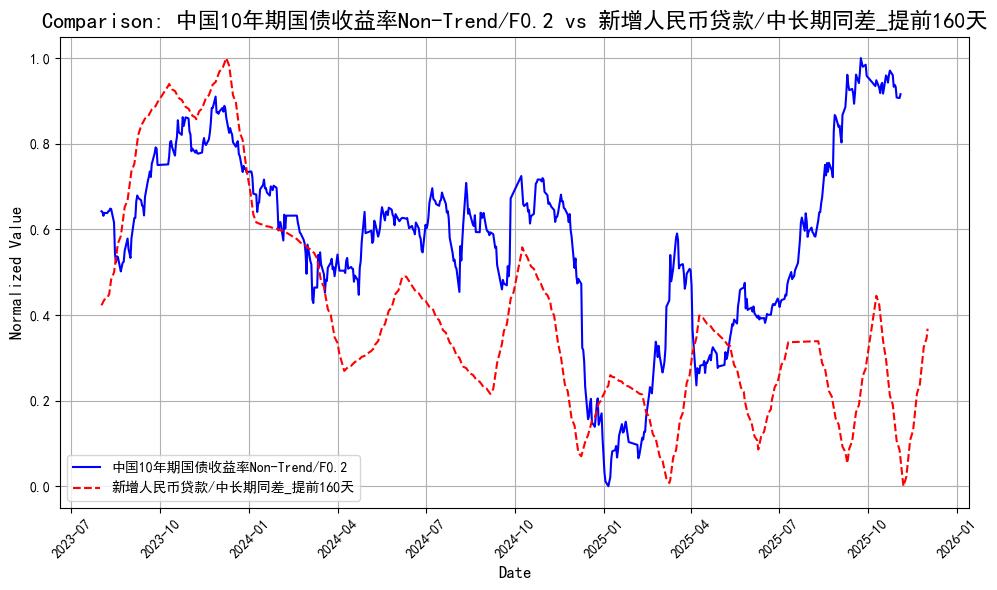

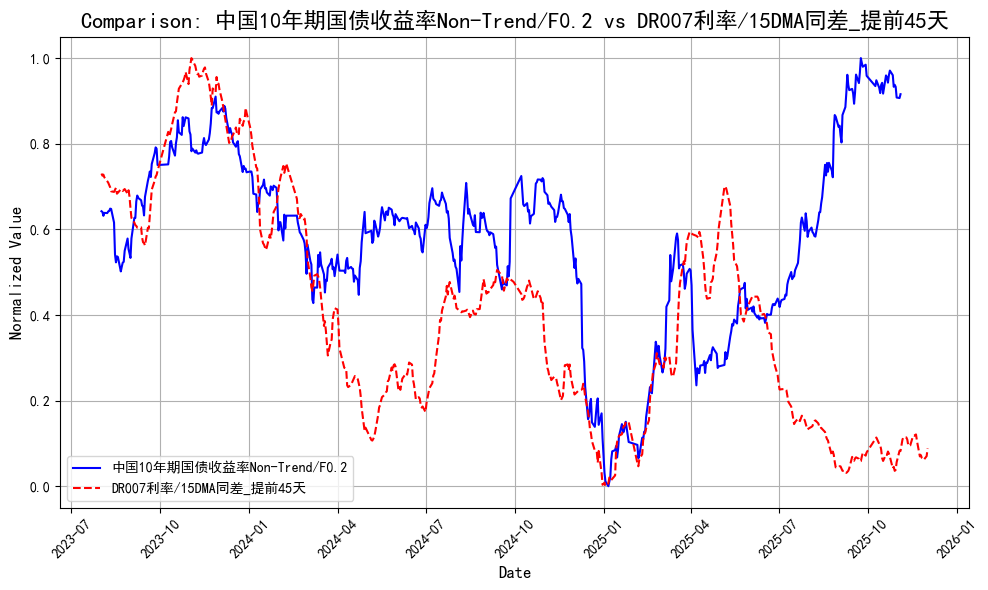

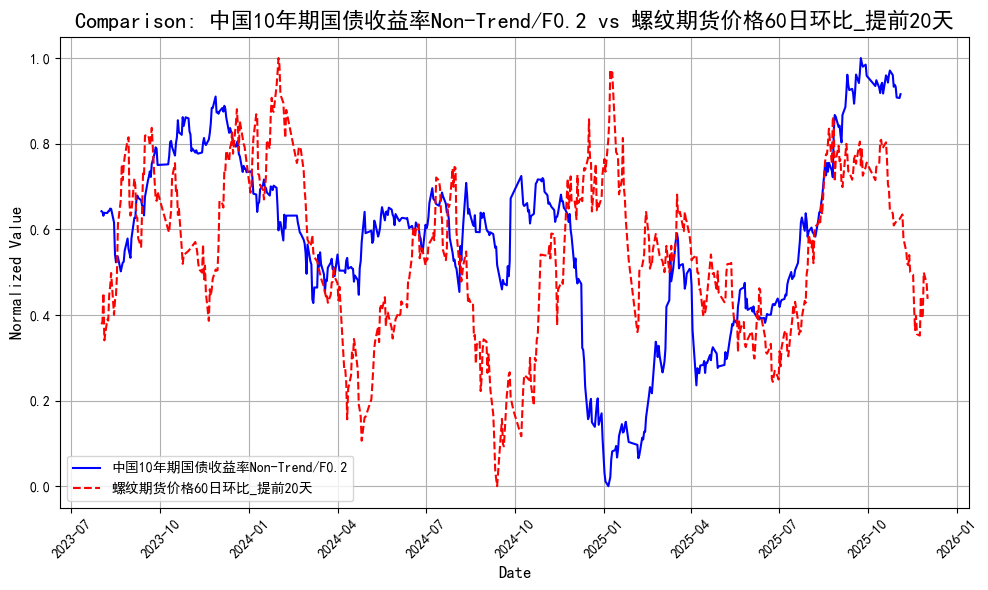

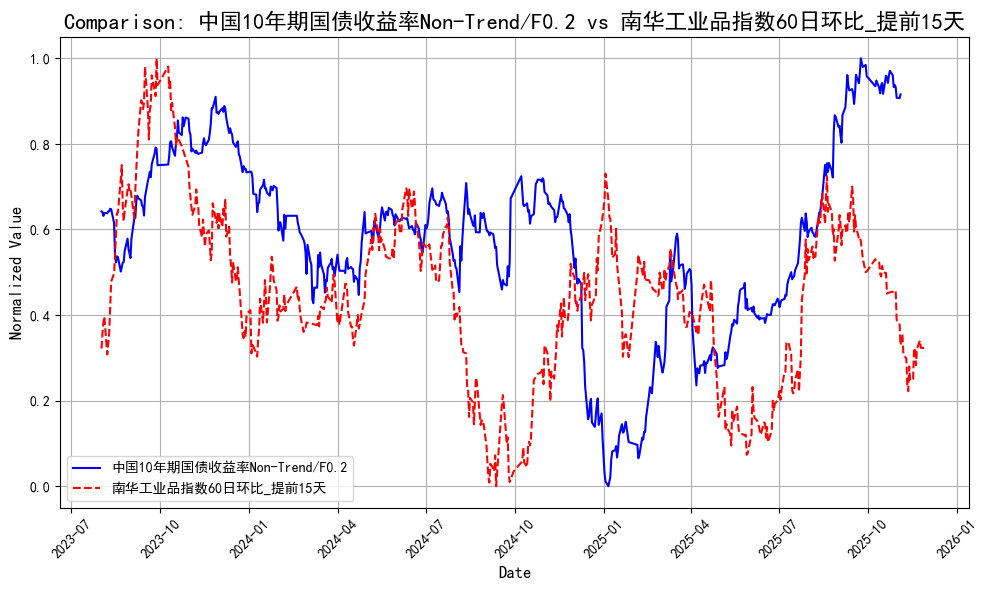

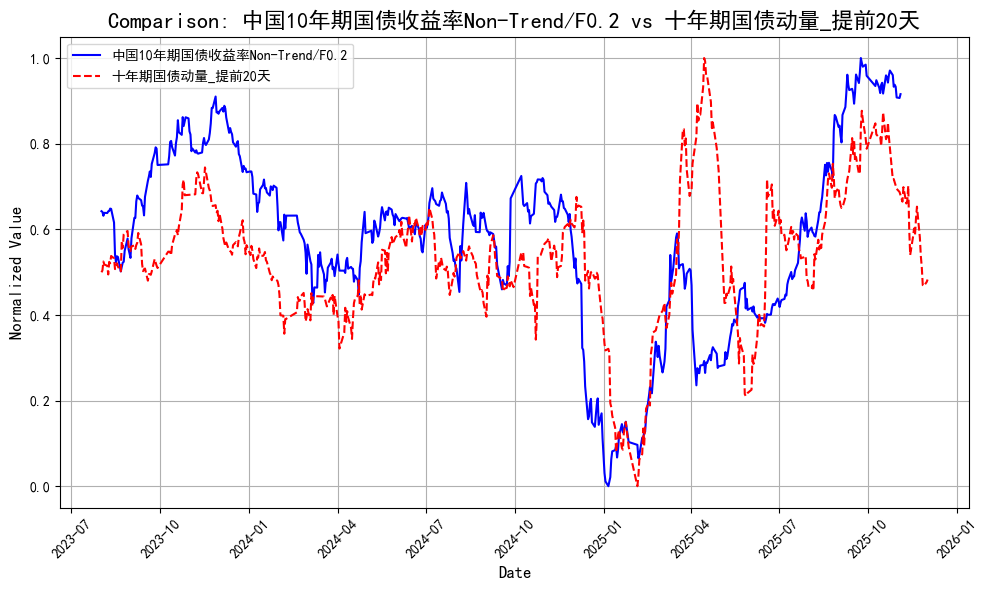

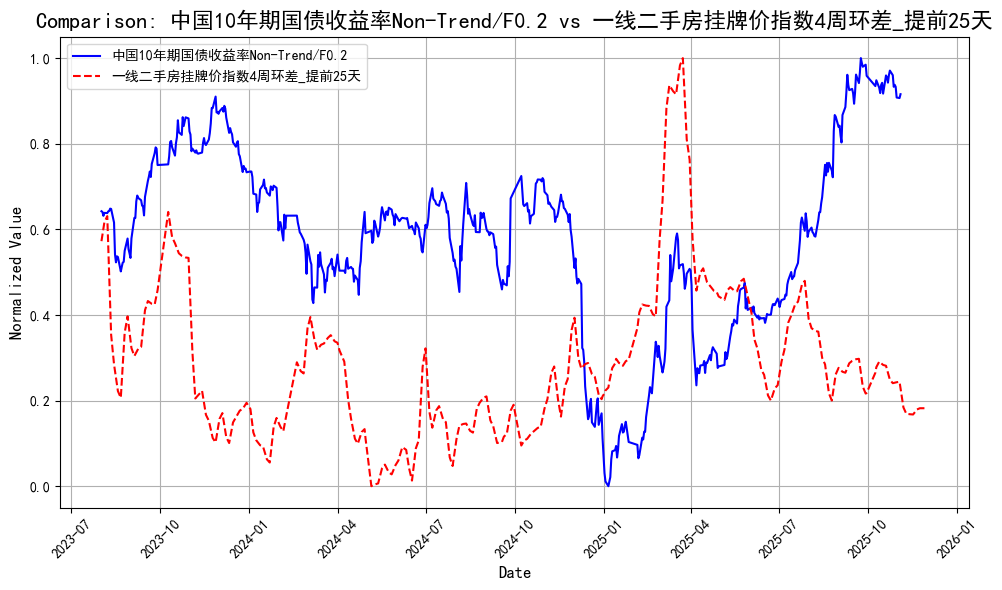

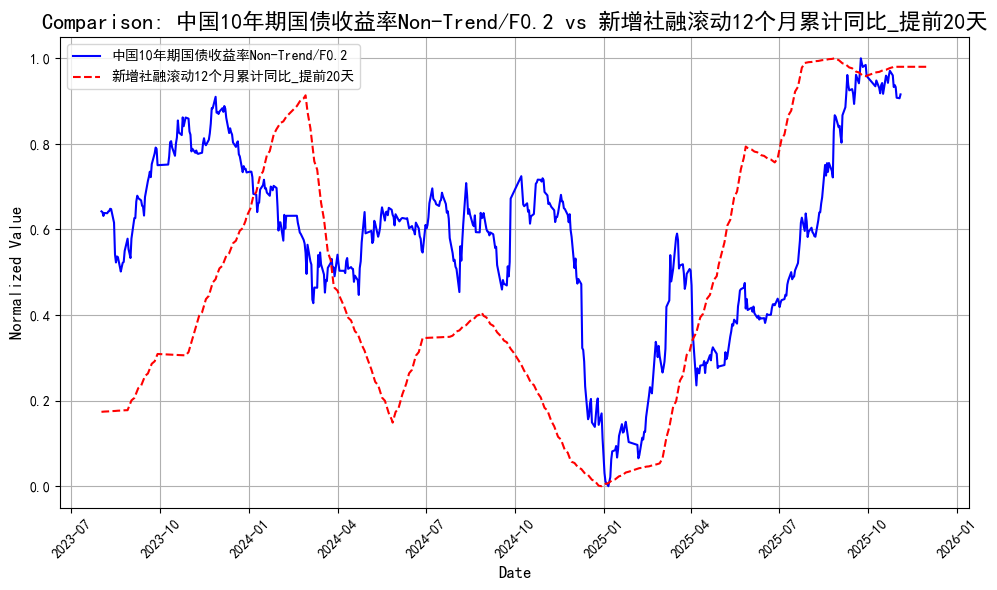

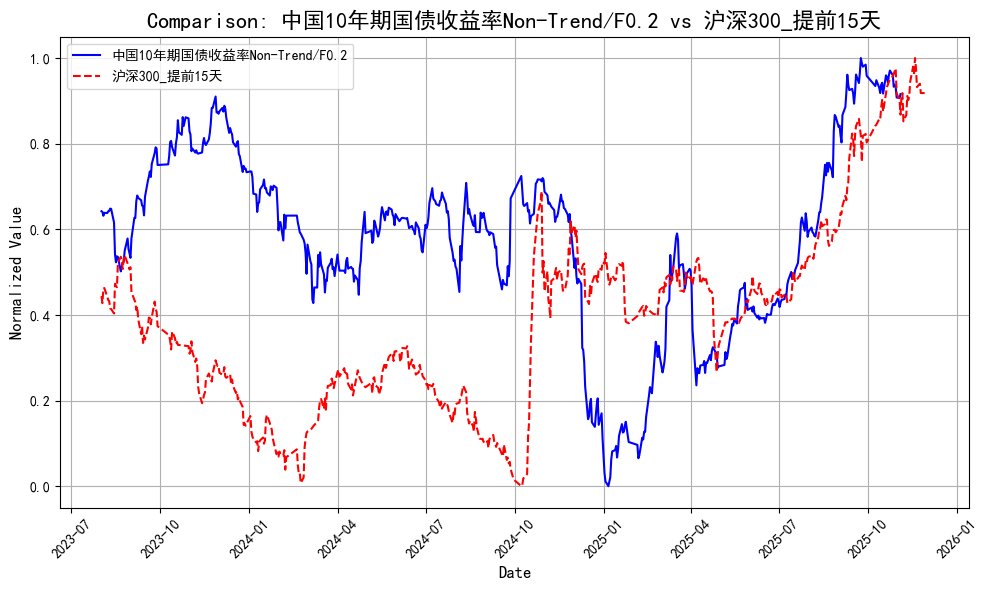

In [53]:
data_filtered_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    data_filtered_plot, 
    main_col='中国10年期国债收益率Non-Trend/F0.2', 
    compare_cols=[
       'M2同比_提前140天', 
        'M1同比_提前60天',
        '新增人民币贷款/中长期同差_提前160天', 
#      '中国核心CPI当月同比_提前55天',
#      '70大中城市二手房价环比Non-Trend/F0.1_提前170天', 
        'DR007利率/15DMA同差_提前45天',
       '螺纹期货价格60日环比_提前20天', 
       '南华工业品指数60日环比_提前15天', 
#       'CNH HIBOR/3M_提前60天',
#       '10年期美国国债收益率Non-Trend/F0.2_提前20天_2023-01-01之后',
       '十年期国债动量_提前20天',
       '一线二手房挂牌价指数4周环差_提前25天',
       '新增社融滚动12个月累计同比_提前20天',
       '沪深300_提前15天',
                  ]
)

In [54]:

# 划分训练集、测试集和未来数据
train_data = sheet_daily[sheet_daily['Date'] <= last_day]
test_period = 15
test_data = train_data[-test_period:]  
train_data = train_data[:-test_period]  
future_data = sheet_daily[sheet_daily['Date'] > last_day]


In [55]:
feature_columns = [
        'M2同比_提前140天', 
        'M1同比_提前60天',
#        '新增人民币贷款/中长期同差_提前160天', 
        #'中国核心CPI当月同比_提前55天',
        #'70大中城市二手房价环比Non-Trend/F0.1_提前170天', 
        #'DR007利率/15DMA同差_提前45天',
#        '螺纹期货价格60日环比_提前20天', 
#        '南华工业品指数60日环比_提前15天', 
        #'CNH HIBOR/3M_提前60天',
        #'10年期美国国债收益率Non-Trend/F0.2_提前20天_2023-01-01之后',
        '十年期国债动量_提前20天',
        #'一线二手房挂牌价指数4周环差_提前25天',
#        '新增社融滚动12个月累计同比_提前20天',
        '沪深300_提前15天',
        '沪深300_提前16天',
        '沪深300_提前20天',
]


# 准备训练、测试和未来数据的输入和输出
X_train = train_data[feature_columns]
y_train = train_data['中国10年期国债收益率Non-Trend/F0.2']

X_test = test_data[feature_columns]
y_test = test_data['中国10年期国债收益率Non-Trend/F0.2']

X_future = future_data[feature_columns]

In [56]:

# 正则化所有input 选择standard 因为金融数据 会超过过往极值的问题
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

# 创建DMatrix对象,设置样本权重以降低异常值的影响
train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 60)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.01,  # 较小的学习率
    'max_depth': 9,  # 控制树的深度防止过拟合
    'min_child_weight': 0.3,  # 控制过拟合
    'subsample': 0.6,  # 随机采样防止过拟合
    'colsample_bytree': 0.3,  # 特征随机采样
    'gamma': 0.01,  # 控制分裂
    'reg_alpha': 0.01,  # L1正则化
    'reg_lambda': 0.02,  # L2正则化
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
}



# 训练模型，使用早停策略，最大训练轮数
num_boost_round = 1000
# 记录评估指标、储
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=100 # 每100轮输出一次评估信息
)

# 训练集预测
y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
# 测试集预测
y_test_pred_dmatrix = model.predict(test_dmatrix)

# 计算 MSE 和 R² 分数
# 计算训练集和测试集的MSE
train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
# 计算训练集和测试集的R²
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
# 打印结果
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
# 测试预测 存储
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
# 未来预测 存储
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:0.23387	train-rmse:0.10302


[100]	eval-rmse:0.14932	train-rmse:0.06911
[200]	eval-rmse:0.10496	train-rmse:0.05508
[300]	eval-rmse:0.08237	train-rmse:0.04848
[400]	eval-rmse:0.07282	train-rmse:0.04525
[500]	eval-rmse:0.06903	train-rmse:0.04357
[600]	eval-rmse:0.06748	train-rmse:0.04242
[700]	eval-rmse:0.06696	train-rmse:0.04158
[800]	eval-rmse:0.06597	train-rmse:0.04109
[900]	eval-rmse:0.06542	train-rmse:0.04074
[999]	eval-rmse:0.06516	train-rmse:0.04053
训练集 MSE (DMatrix): 0.0023, 训练集 R² (DMatrix): 0.8715
测试集 MSE (DMatrix): 0.0042, 测试集 R² (DMatrix): -25.0288


C:\Users\Hz\AppData\Local\Temp\ipykernel_12768\1373329552.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_data.loc[:, '预测值'] = y_future_pred_dmatrix


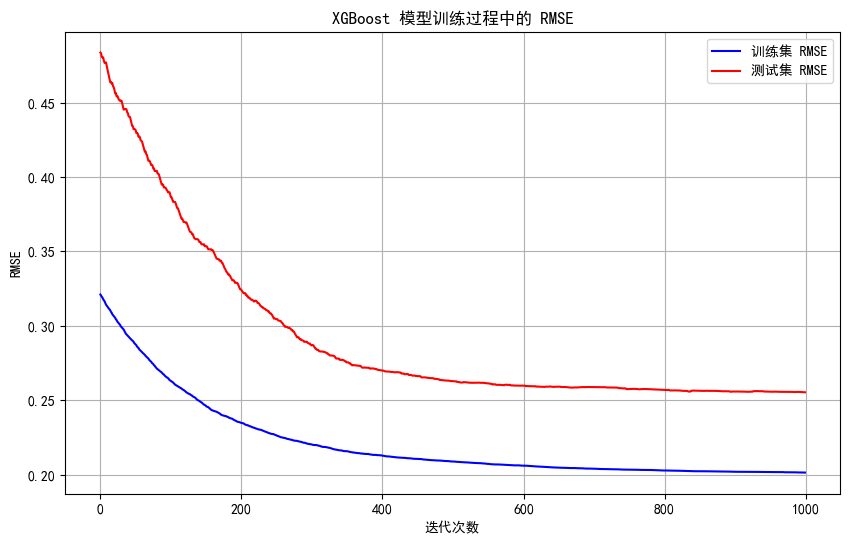

In [57]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [58]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################

# 确保数据拼接后索引是连续的，防止数据对不齐
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

# 对所有数据进行标准化（使用之前拟合的 scaler）
X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重


# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=100
)

# 对全部数据进行预测（X_train + X_test）
y_all_pred = model_all.predict(all_data_dmatrix)

# 对未来数据进行预测
y_future_pred_all = model_all.predict(future_dmatrix_all)

# 计算全部数据的 MSE 和 R² 分数
all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

# 打印结果
print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred

# 存储未来预测结果
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:0.10565
[100]	train-rmse:0.06964
[200]	train-rmse:0.05480
[300]	train-rmse:0.04804
[400]	train-rmse:0.04475
[500]	train-rmse:0.04303
[600]	train-rmse:0.04185
[700]	train-rmse:0.04098
[800]	train-rmse:0.04051
[900]	train-rmse:0.04017
[999]	train-rmse:0.03991
全部数据 MSE: 0.0022, 全部数据 R²: 0.8839


C:\Users\Hz\AppData\Local\Temp\ipykernel_12768\2282244843.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_data.loc[:, '预测值_全量'] = y_future_pred_all


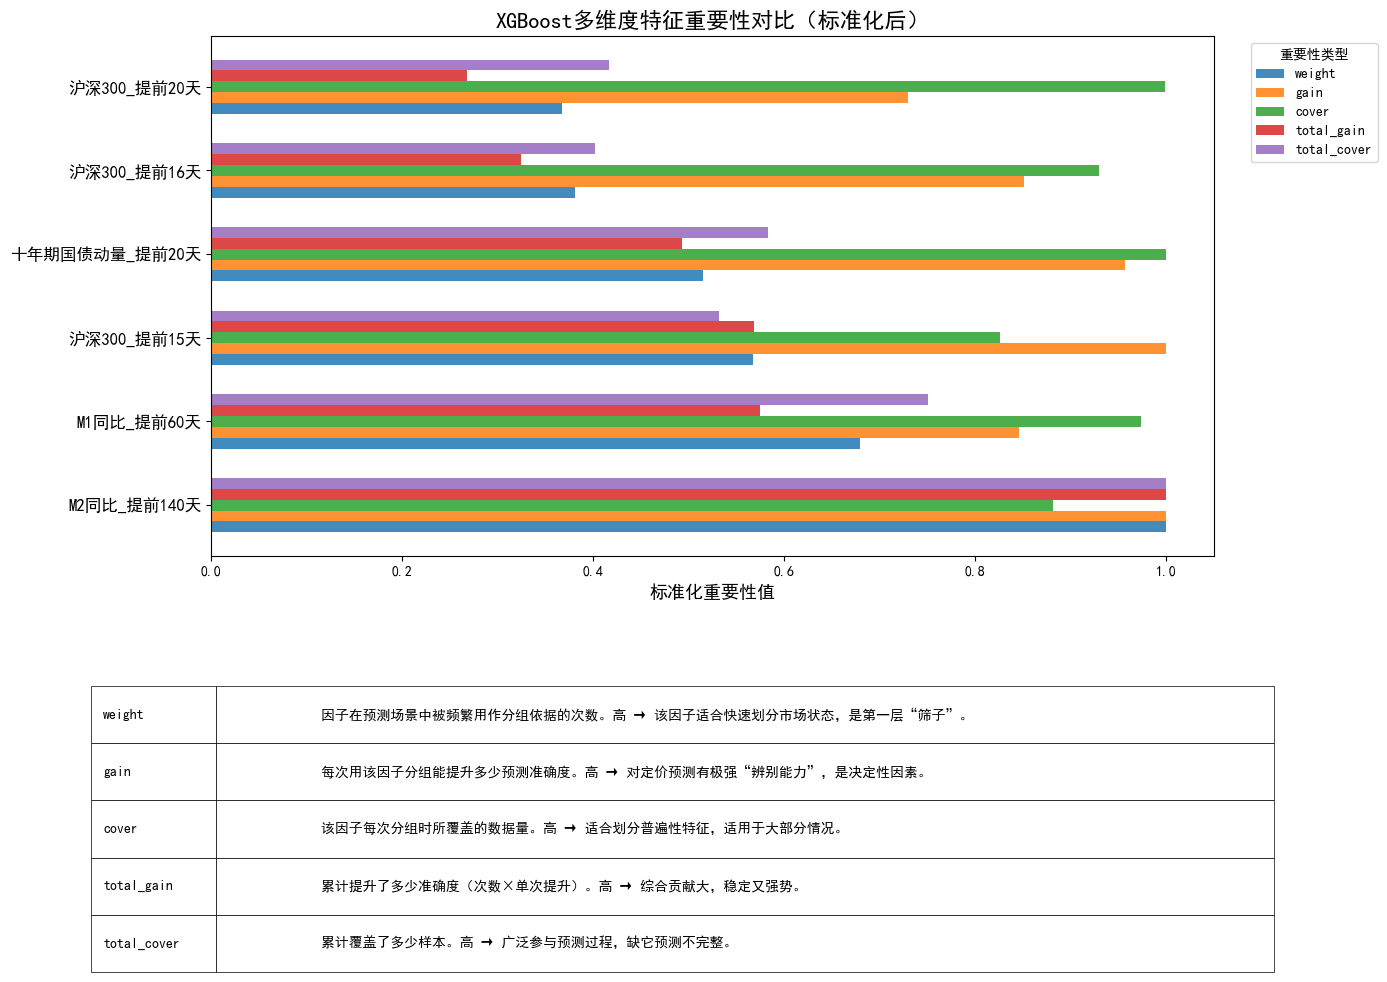

,weight,gain,cover,total_gain,total_cover
M2同比_提前140天,1.000000,0.999920,0.881963,1.000000,1.000000
M1同比_提前60天,0.679455,0.846037,0.973955,0.574890,0.750325
沪深300_提前15天,0.568069,1.000000,0.826171,0.568115,0.532134
十年期国债动量_提前20天,0.514851,0.957152,1.000000,0.492831,0.583756
沪深300_提前16天,0.381188,0.850923,0.929904,0.324388,0.401909
沪深300_提前20天,0.367574,0.730097,0.999541,0.268386,0.416577


In [59]:
#绘制因子重要性
plot_xgb_feature_importance(model_all, X_train)


In [60]:
#####注意替换
# 交换 '预测值_全量' 和 '预测值' 列名
future_data = future_data.rename(columns={'预测值_全量': '预测值_temp',  '预测值': '预测值_全量'})
future_data = future_data.rename(columns={'预测值_temp': '预测值' })
#####


Gap between last actual value and first prediction: 0.013089396333694464


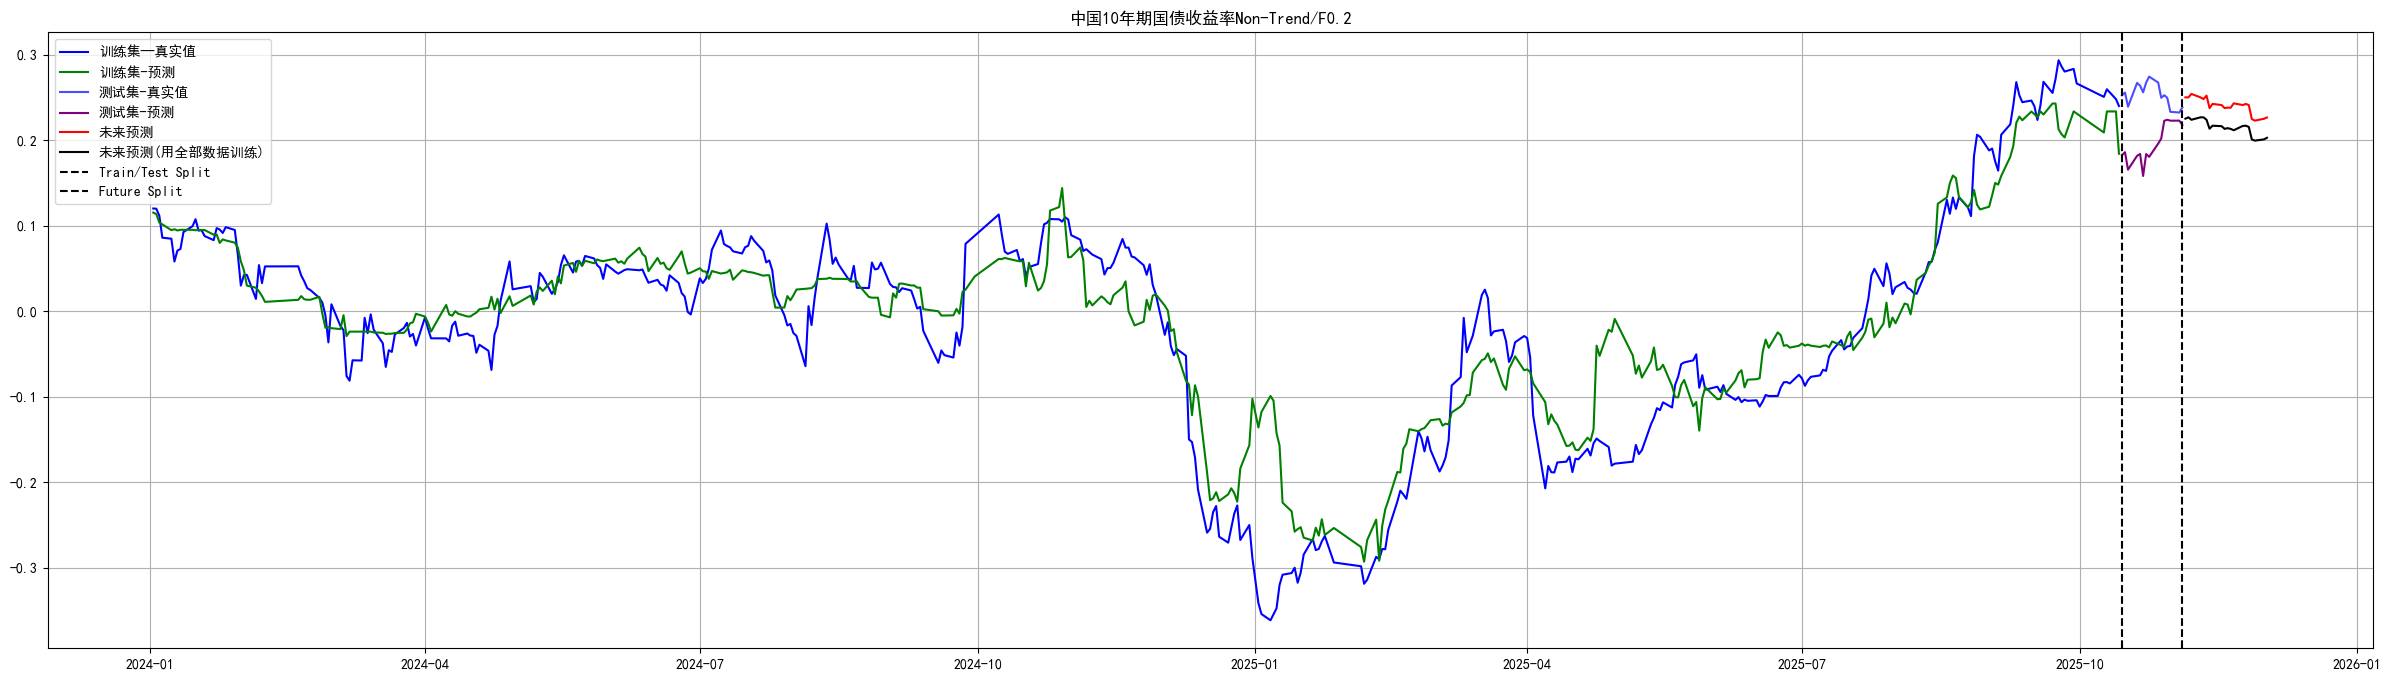

In [61]:

plt.figure(figsize=(30, 8))
future_data = plot_predictions(y_test, future_data, col=True, label=True)

# 只显示2024年及以后的数据
mask_train = train_data['Date'].dt.year >= 2024
mask_test = test_data['Date'].dt.year >= 2024
mask_future = future_data['Date'].dt.year >= 2024

plt.plot(train_data.loc[mask_train, 'Date'], y_train[mask_train], label='训练集—真实值', color='blue')
plt.plot(train_data.loc[mask_train, 'Date'], y_train_pred_dmatrix[mask_train], label='训练集-预测', color='green')
plt.plot(test_data.loc[mask_test, 'Date'], y_test[mask_test], label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data.loc[mask_test, 'Date'], y_test_pred_dmatrix[mask_test], label='测试集-预测', color='purple')
plt.plot(future_data.loc[mask_future, 'Date'], future_data.loc[mask_future, '预测值'], label='未来预测', color='red')
plt.plot(future_data.loc[mask_future, 'Date'], future_data.loc[mask_future, '预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 在同一张图中添加真实数据线
#plt.plot(real_data['Date'], real_data['中国10年期国债收益率Non-Trend/F0.2'], label='未来30天真实值', color='orange', linestyle='--', linewidth=2)

plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')
plt.title('中国10年期国债收益率Non-Trend/F0.2')
plt.legend()
plt.grid(True)
plt.show()

---

In [62]:
'''
# 交换 '预测值_全量' 和 '预测值' 列名
future_data = future_data.rename(columns={
    '预测值_全量': '预测值_temp',  # 临时列名
    '预测值': '预测值_全量'
})

future_data = future_data.rename(columns={
    '预测值_temp': '预测值'  # 完成交换
})
'''
# 任务1: 合并训练集、测试集真实值和未来预测
# 获取2023年以后的训练集数据
train_data_2023 = train_data[train_data['Date'].dt.year >= 2023][['Date', '中国10年期国债收益率Non-Trend/F0.2']]
test_actual = test_data[['Date', '中国10年期国债收益率Non-Trend/F0.2']]
# 合并训练集和测试集的真实值
historical_actual = pd.concat([train_data_2023, test_actual])
historical_actual.columns = ['Date', '实际值']


# 获取未来预测值
future_pred = future_data[['Date', '预测值_全量']]  # 修改这里的列名
# 合并所有数据
merged_df = pd.merge(historical_actual, future_pred, on='Date', how='outer')
# 将日期格式转换为年/月/日格式
merged_df['Date'] = merged_df['Date'].dt.strftime('%Y/%m/%d')
merged_df = merged_df.sort_values('Date', ascending=False)
# 保存到Excel
merged_df.to_excel('eta/中国10年期国债收益率Non-Trend_合并数据.xlsx', index=False,float_format='%.5f')
merged_df

,Date,实际值,预测值_全量
566,2025/12/02,NaN,0.202616
565,2025/12/01,NaN,0.200757
564,2025/11/28,NaN,0.199318
563,2025/11/27,NaN,0.200757
562,2025/11/26,NaN,0.215374
...,...,...,...
4,2023/08/07,0.0562,NaN
3,2023/08/04,0.0565,NaN
2,2023/08/03,0.0520,NaN
1,2023/08/02,0.0580,NaN


In [63]:
# 任务2: 生成月度数据
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')

# 保存月度数据
merged_df_monthly.to_excel('eta/中国10年期国债收益率Non-Trend_月度数据.xlsx', index=False,float_format='%.2f')
merged_df_monthly.head()                       


,Date,真实值,预测值
28,2025/12/31,NaN,0.201687
27,2025/11/30,0.235150,0.216947
26,2025/10/31,0.254318,0.196889
25,2025/09/30,0.240914,0.203777
24,2025/08/31,0.091433,0.084071


---

In [64]:
future_predictions_nontrend = merged_df[['Date', '预测值_全量']]
future_predictions_nontrend = future_predictions_nontrend.dropna()
future_predictions_nontrend['Date'] = pd.to_datetime(future_predictions_nontrend['Date'])
future_predictions_nontrend = future_predictions_nontrend.sort_values('Date')
future_predictions_nontrend.to_csv('data_output/中国10年期国债收益率Non-Trend-F0.2_未来日度预测.csv', index=False)
future_predictions_nontrend.head()

,Date,预测值_全量
547,2025-11-05,0.225011
548,2025-11-06,0.226572
549,2025-11-07,0.223726
550,2025-11-10,0.226572
551,2025-11-11,0.226572


---

In [65]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "中国10年期国债收益率Non-Trend/F0.2"

# 调用函数更新数据
success = update_excel_data(merged_df, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [66]:
from Lcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "详情页"
identifier = "中国10年期国债收益率Non-Trend/F0.2"

# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列
已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件


In [67]:
'''
from Ecel import generate_and_fill_excel
success = generate_and_fill_excel(
    daily_df =  merged_df,
    target_name = '中国10年期国债收益率Non-Trend/F0.2',        # 写入的"预测标的"显示名
    TARGET_COL = '预测值_全量',
    output_path='update.xlsx'
)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")
    '''

'\nfrom Ecel import generate_and_fill_excel\nsuccess = generate_and_fill_excel(\n    daily_df =  merged_df,\n    target_name = \'中国10年期国债收益率Non-Trend/F0.2\',        # 写入的"预测标的"显示名\n    TARGET_COL = \'预测值_全量\',\n    output_path=\'update.xlsx\'\n)\n\nif success:\n    print("数据已成功更新到Excel文件")\nelse:\n    print("数据更新失败，请检查错误信息")\n    '